# 04_Data_Analysis

File to analyse the towers by sizes, type, split. 
This file also generates Figures within the Data and Exp. 2 section. 

Some sub-sections/-functions for plotting have been adapted from chatGPT output. 

In [2]:
import os
import sys
import json
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import matplotlib as mpl
import latex
import glob


In [ ]:

import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import metrics
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("seaborn-v0_8-colorblind")

## Number of images in train/test per location

In [4]:
base_path = "/workspace/data"

os.chdir(base_path)

jf = open("labels_train_new.json")
labels_train = json.load(jf)


jf = open("labels_val.json")
labels_val = json.load(jf)

jf = open("labels_test.json")
labels_test = json.load(jf)

In [4]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np

# Load the COCO dictionaries
with open('labels_train_new.json', 'r') as f:
    train_dict = json.load(f)
    
with open('labels_val.json', 'r') as f:
    val_dict = json.load(f)
    
with open('labels_test.json', 'r') as f:
    test_dict = json.load(f)

    

location_mapping = {'AR': 'USA',
 'CH': 'China', 
 'CL': 'USA', 
 'DU': 'New Zealand', 
 'GI': 'New Zealand', 
 'KA': 'USA', 
 'ME': 'Mexico', 
 'PA': 'New Zealand', 
 'RO': 'New Zealand', 
 'SU': 'Sudan', 
 'TA': 'New Zealand', 
 'WI': 'USA'}

category_dict = {0: 'Distribution', 1: 'Transmission'}    

# Create a dictionary to store the counts by location and category
counts = {}

image_id = None
for dataset, dataset_dict in zip(['train', 'val', 'test'], [train_dict, val_dict, test_dict]):
    # Create a dictionary to map image IDs to file names
    id_to_filename = {img['id']: img['file_name'] for img in dataset_dict['images']}
    for annotation in dataset_dict['annotations']:
        # Get the file name from the image ID in the annotation
        file_name = id_to_filename[annotation['image_id']]
        # Extract the location from the image filepath
        location = location_mapping[file_name[:2]]
        if location not in counts:
            counts[location] = {}
        
        # Extract the category from the annotation
        category_id = annotation['category_id']
        category = category_dict[category_id]
        if category not in counts[location]:
            counts[location][category] = [0, 0, 0]
        
        # Only count the first annotation for each image ID
        if annotation['image_id'] != image_id:
            image_id = annotation['image_id']
            # Increment the count for the appropriate split
            if dataset == 'train':
                counts[location][category][0] += 1
            elif dataset == 'val':
                counts[location][category][1] += 1
            elif dataset == 'test':
                counts[location][category][2] += 1

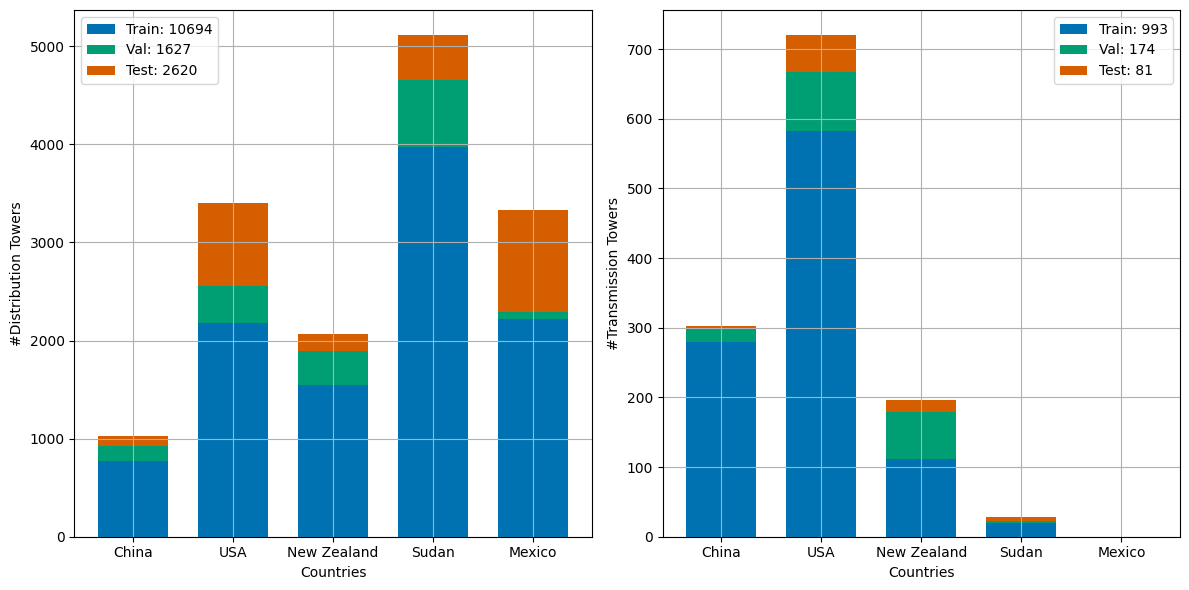

In [7]:
# Get the country names and the data for each category
countries = list(counts.keys())
distribution_data = [counts[c]['Distribution'] for c in countries]
transmission_data = [counts[c]['Transmission'] if 'Transmission' in counts[c] else [0,0,0] for c in countries]

# Set up the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
index = np.arange(len(countries))
bar_width = 0.7
totals = {'transmission':{}, 'distribution':{}}
# Plot the distribution data
bottom = [0] * len(countries)

for i, mode in enumerate(['Train', 'Val', 'Test']):
    
    y = [d[i] for d in distribution_data]
    totals['distribution'][mode] = sum(y)
    ax1.bar(index, y, bar_width, bottom=bottom, label=mode)
    bottom = [bottom[j] + distribution_data[j][i] for j in range(len(countries))]
    
ax1.set_xlabel('Countries')
ax1.set_ylabel('#Distribution Towers')
ax1.set_xticks(index)
ax1.set_xticklabels(countries)
ax1.legend([f"Train: {totals['distribution']['Train']}",
           f"Val: {totals['distribution']['Val']}", 
           f"Test: {totals['distribution']['Test']}"])
ax1.grid()

# Plot the transmission data
bottom = [0] * len(countries)
for i, mode in enumerate(['Train', 'Val', 'Test']):
    y = [d[i] for d in transmission_data]
    totals['transmission'][mode] = sum(y)
    
    ax2.bar(index, y, bar_width, bottom=bottom, label=mode)
    bottom = [bottom[j] + transmission_data[j][i] for j in range(len(countries))]
        
ax2.set_xlabel('Countries')
ax2.set_ylabel('#Transmission Towers')
ax2.set_xticks(index)
ax2.set_xticklabels(countries)
ax2.legend([f"Train: {totals['transmission']['Train']}",
           f"Val: {totals['transmission']['Val']}", 
           f"Test: {totals['transmission']['Test']}"])
ax2.grid()

plt.tight_layout()
plt.show()

In [20]:
print(distribution_data)

[[775, 149, 100], [2178, 380, 844], [1547, 349, 174], [3971, 684, 459], [2223, 65, 1043]]


In [8]:
total = 0
for m in ['Train', 'Val', 'Test']:
    c = 0
    for i in totals:
        
        c += totals[i][m]
    
    print(m, c)
    total += c
print('total', total)

Train 11687
Val 1801
Test 2701
total 16189


## Looking at the training set towers

The towers can be duplicated due to the way the images are cut. If multiple towers are close to each other, then there are multiple towers in an image

In [129]:
locations_towers_with_duplicates_train = [location_train[tower['image_id']-1] for tower in labels_train['annotations']]
locations_towers_with_duplicates_val = [location_val[tower['image_id']-1]for tower in labels_val['annotations']]


In [130]:
len(locations_towers_with_duplicates_train)

55059

[ 1328  4460  1655   710  1358  2443  7864  1134   535 40527  1176   758]


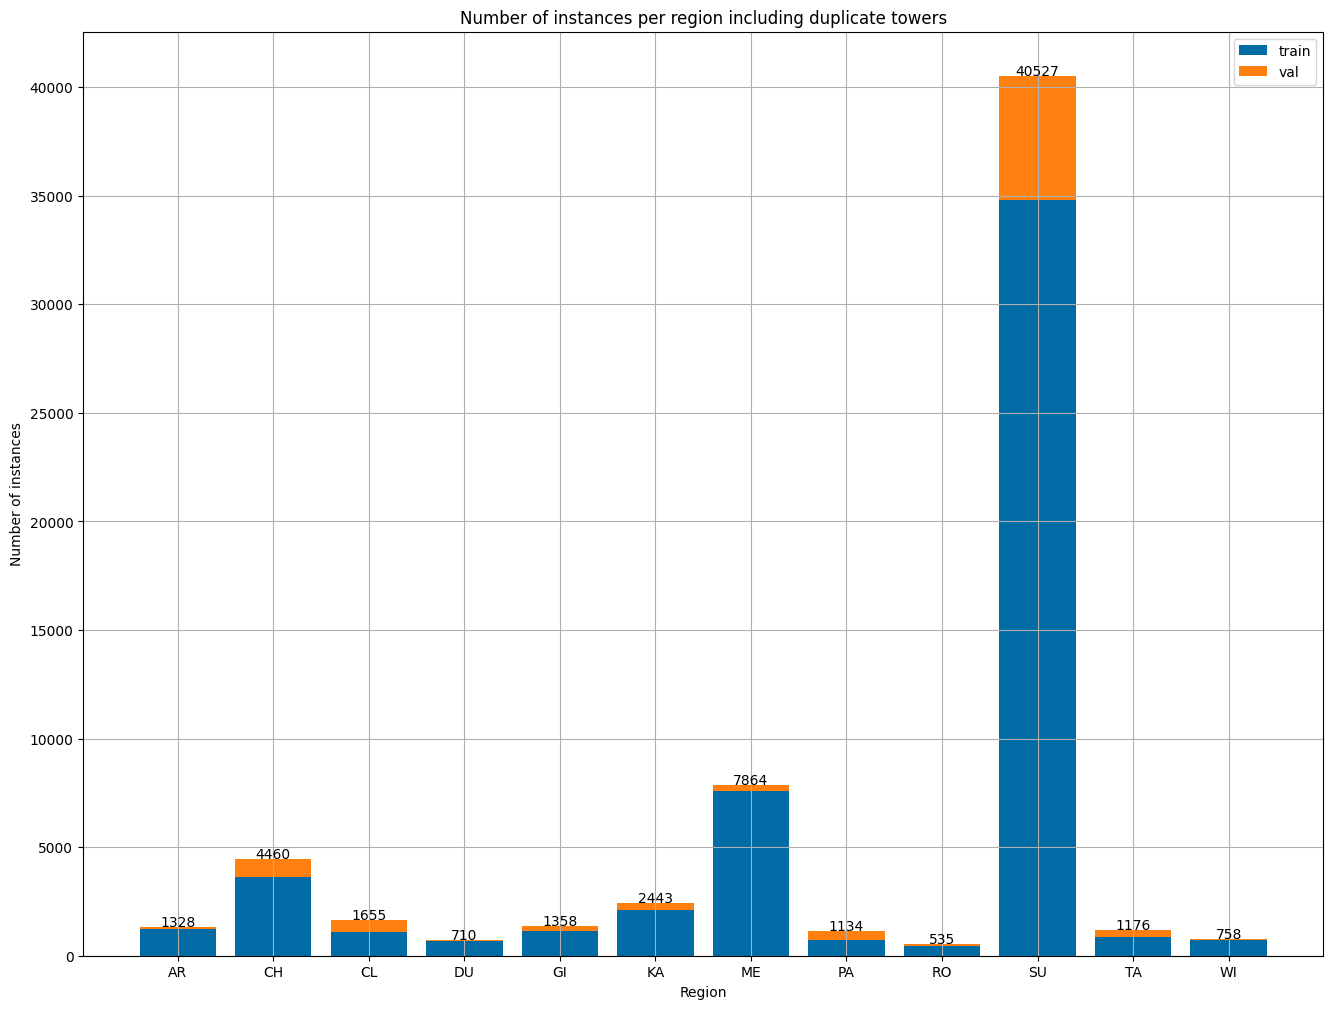

In [131]:
location_count_train = sorted(set([(t, locations_towers_with_duplicates_train.count(t)) for t in locations_towers_with_duplicates_train]))
location_count_val = sorted(set([(t, locations_towers_with_duplicates_val.count(t)) for t in locations_towers_with_duplicates_val]))

lo_train = [lo[0] for lo in location_count_train]
lo_val = [lo[0] for lo in location_count_val]

co_train = [lo[1] for lo in location_count_train]
co_val = [lo[1] for lo in location_count_val]

co_total = np.asarray(co_train) + np.asarray(co_val)
print(co_total)

plt.figure(figsize = (16,12))
plt.style.use("tableau-colorblind10")

#plot

plt.bar(lo_train, co_train, label = 'train')
plt.bar(lo_val, co_val, bottom = co_train, label = 'val')

# Add labels and title
plt.xlabel('Region')
plt.ylabel('Number of instances')
plt.title('Number of instances per region including duplicate towers')
plt.grid()

# Add ticks on the x-axis
#plt.xticks(rotation = 45)

# Add the total values on top of the bars
for i, total in enumerate(co_total):
    plt.text(x=i, y=total+20, s=f'{total}', ha='center')

# Show the legend
plt.legend()

# Display the plot
plt.show()


## Number of towers per image

In [5]:
df_towers = pd.DataFrame.from_dict(labels_train['annotations'])

In [6]:
towers_per_image = df_towers.value_counts("image_id")

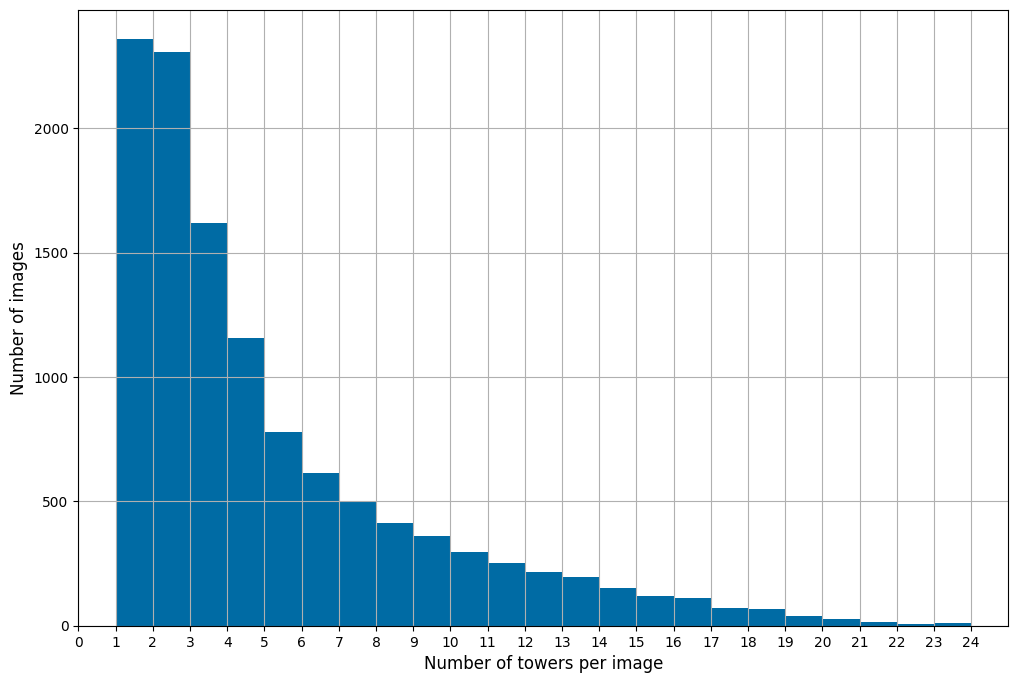

In [10]:
plt.figure(figsize = (12,8))
plt.style.use("tableau-colorblind10")

bin_list = [i for i in range(0,25)]
plt.hist(towers_per_image, bins = bin_list)

# Add labels and title
plt.xlabel('Number of towers per image',fontsize='large')
plt.xlim(1,25)
plt.ylabel('Number of images',fontsize='large')
#plt.title('Number of instances per region including duplicate towers')
plt.grid()

#Add ticks on the x-axis
plt.xticks(bin_list)

plt.savefig(f"/workspace/figures/tower_per_image.png", 
            bbox_inches = 'tight',
            pad_inches = .25)

# Display the plot
plt.show()



## Code snippet to delete directories 

In [135]:
# file_list = os.listdir()

# for i in file_list:
    
#     if 'output' in i:
#         !rm -r {i}

# Tower sizes

In [9]:
base_path = "/workspace/data"

#os.chdir(base_path)

jf = open(base_path+"/labels_train_DT.json")
labels_train = json.load(jf)

jf = open(base_path+"/labels_val.json")
labels_val = json.load(jf)

jf = open(base_path+"/labels_test.json")
labels_test = json.load(jf)

In [10]:
unique_train = []
unique_val = []

for i in labels_train['annotations']:
    if i not in unique_train:
        unique_train.append(i)
        
for i in labels_val['annotations']:
    if i not in unique_val:
        unique_val.append(i)


sizes_train = np.asarray([i['bbox'][2:4] for i in unique_train])
sizes_val = np.asarray([i['bbox'][2:4] for i in unique_val])

In [12]:
unique_test = []
for i in labels_test['annotations']:
    if i not in unique_test:
        unique_test.append(i)


sizes_test = np.asarray([i['bbox'][2:4] for i in unique_test])

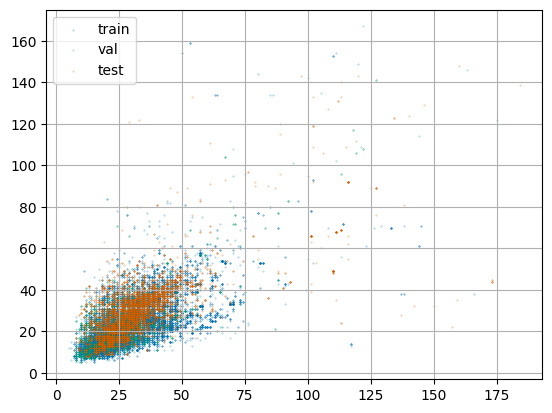

In [13]:
plt.scatter(sizes_train[:,0], sizes_train[:,1], s =.1, alpha = .5, label = 'train')
plt.scatter(sizes_val[:,0], sizes_val[:,1], s =.1, alpha = .5, label = 'val')
plt.scatter(sizes_test[:,0], sizes_test[:,1], s =.1, alpha = .5, label = 'test')
plt.legend()
plt.grid()
plt.show()

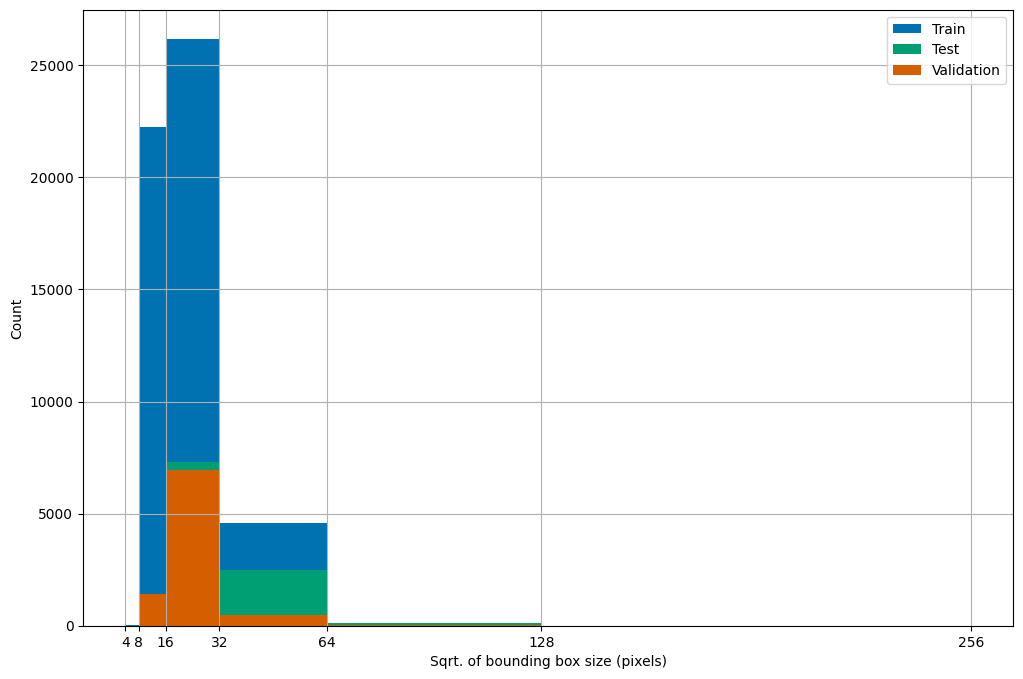

In [19]:
import math
plt.figure(figsize = (12,8))
plt.hist([(i**.5) for i in (sizes_train[:,0]*sizes_train[:,1])], bins = [4, 8, 16, 32, 64,128,256], label = 'Train')
plt.hist([(i**.5) for i in (sizes_test[:,0]*sizes_test[:,1])], bins = [4, 8, 16, 32, 64,128,256], label = 'Test')
plt.hist([(i**.5) for i in (sizes_val[:,0]*sizes_val[:,1])], bins = [4, 8, 16, 32, 64, 128, 256], label = 'Validation')
plt.xticks([4, 8, 16, 32, 64,128,256])
plt.xlabel('Sqrt. of bounding box size (pixels)')
plt.ylabel('Count')
plt.legend()
plt.grid()

plt.savefig('/workspace/figures/bounding_box_size.png', pad_inches = 0, bbox_inches = 0)
plt.show()

In [187]:
len(unique_train)

53154

In [182]:
np.mean([(i**.5) for i in (sizes_train[:,0]*sizes_train[:,1])])

72.73773308251494

In [188]:
np.mean([(i**.5) for i in (sizes_train[:,0]*sizes_train[:,1])])

20.020133817714193

In [189]:
72

5184

# Exp 2 - Understand image colors by location

In [68]:
import cv2

list_images = glob.glob('/workspace/data/data_030/train/data/*')

image = cv2.imread('/workspace/data/data_030/train/data/AR_100.48219445896311_10483.358440544871_795.png')

In [69]:
means = np.mean(image, axis=tuple(range(image.ndim-1)))

In [70]:
location_mapping = {'AR': 'USA',
 'CH': 'China', 
 'CL': 'USA', 
 'DU': 'New Zealand', 
 'GI': 'New Zealand', 
 'KA': 'USA', 
 'ME': 'Mexico', 
 'PA': 'New Zealand', 
 'RO': 'New Zealand', 
 'SU': 'Sudan', 
 'TA': 'New Zealand', 
 'WI': 'USA'}


location = []
im_vec = []
red = []
green = []
blue = []
for im_path in list_images:
    
    #load image 
    image = cv2.imread(im_path)
    
    #record location
    location.append(location_mapping[im_path[36:38]])
    
    means = np.mean(image, axis=tuple(range(image.ndim-1)))
    
    im_vec.append(means)
    red.append(means[0])
    green.append(means[1])
    blue.append(means[2])
    
    

In [71]:
color_df = pd.DataFrame({'location' :location, 
                         'vector': im_vec, 
                         'red': red, 
                         'green': green,
                         'blue': blue})

In [72]:
aggregated = color_df.groupby(['location'], as_index=False).agg({'red':['mean','std'],
                                                   'green':['mean','std'],
                                                   'blue':['mean','std']})

In [73]:
aggregated.columns = ['location', 'red_mean', 'red_std', 'green_mean', 'green_std', 'blue_mean', 'blue_std']

In [74]:
aggregated

,location,red_mean,red_std,green_mean,green_std,blue_mean,blue_std
0,China,98.224067,15.678558,101.479312,14.304345,77.655765,22.909032
1,Mexico,107.541147,17.165421,123.641788,15.514139,127.554529,15.843817
2,New Zealand,96.219140,15.551427,110.379791,12.870036,108.632895,14.931883
3,Sudan,75.006764,17.696188,82.002816,16.778775,94.657692,13.735001
4,USA,100.240876,22.095783,112.435300,22.562755,114.726046,27.289010


In [75]:
rows = []
l = []
for row in aggregated.iterrows():
    l.append(row[1]['location'])
    row_col = []
    row_col.append(row[1]['red_mean'])
    row_col.append(row[1]['green_mean'])
    row_col.append(row[1]['blue_mean'])
    rows.append(row_col)

In [76]:
rows

[[98.22406744211206, 101.47931213740489, 77.65576464033805],
 [107.54114686225483, 123.64178823384411, 127.55452914458913],
 [96.21913973757373, 110.37979084557234, 108.63289513728114],
 [75.00676408829844, 82.00281618639342, 94.65769217068092],
 [100.24087616845517, 112.43530024190348, 114.72604593942235]]

In [77]:
r2 = []
for a in rows:
    r2_sub = []
    for b in rows:
        r2_sub.append(np.linalg.norm(np.array(a)-np.array(b)))
        
    r2.append(r2_sub)
    

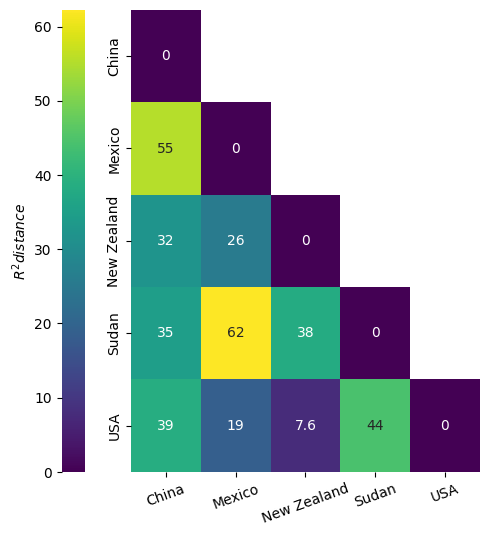

In [78]:
matrix = np.triu(r2)

# gridspec inside gridspec
fig = plt.figure(figsize = (6, 6))

#gs0 = gridspec.GridSpec(1, 2, figure=fig)

#gs00 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[0])

#ax1 = fig.add_subplot(gs00[:, :])

sns.heatmap(r2, annot=True, cmap='viridis', cbar_kws={'label': '$R^2 distance$',
                                                     'location': 'left'}, 
           xticklabels = l, 
           yticklabels = l,
            mask= matrix)
#plt.yticks(visible = False, )
plt.xticks(rotation = 20)
#plt.title('Comparing the R2 distance between mean color values')
plt.savefig('/workspace/figures/r2_distance', bbox_inches = 'tight')
plt.show()

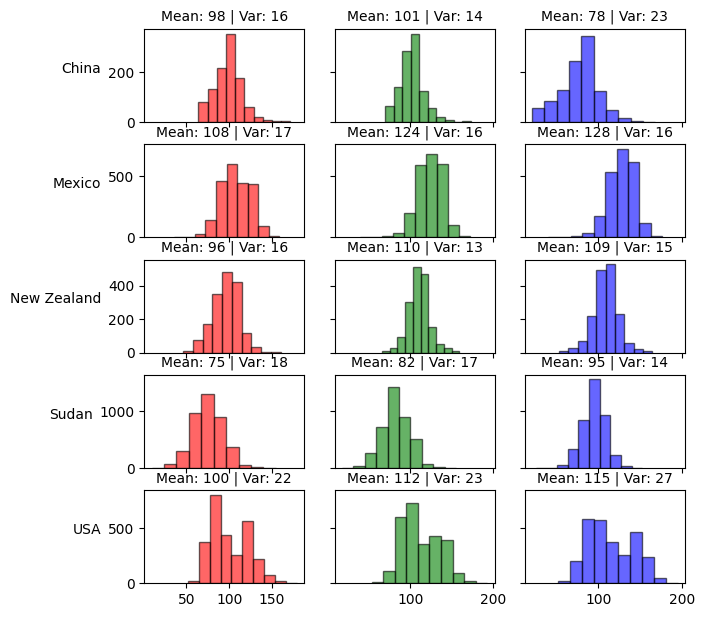

In [79]:
grouped = color_df.groupby('location')

# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(5, 3, figsize=(6, 6), sharex = 'col', sharey = 'row')
fig.tight_layout(pad=0.6)
# Loop through the colors and plot histograms
for c,country in enumerate(l):
    
    for i, color in enumerate(['red','green', 'blue']):

        ax = axes[c, i]
        
        n, bins, patches = ax.hist(color_df[color_df['location'] == country][color].values, 
                color = color, edgecolor='k', alpha =.6)
        #ax.adjust(bottom = .2)

        ax.set_title(f'Mean: {round(rows[c][i])} | Var: {round(aggregated[aggregated["location"]==country][f"{color}_std"].values[0])}', fontsize =10)
        if i == 0:
            ax.set_ylabel(country, rotation = 0, labelpad = 5, horizontalalignment = 'right')
        # Set title and labels for the current subplot
        #ax.set_xlim((0,256))

# Show the plot
plt.savefig('/workspace/figures/color_distribution', bbox_inches = 'tight')
plt.show()

# Explorative Analysis to Clustering the images by color

In [17]:
# Specify the number of clusters
n_clusters = 5

# Perform k-means clustering
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit([list(vec) for vec in color_df['vector'].values])



/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=5)

In [18]:
found_label = kmeans.labels_

In [19]:
color_df['kmeans_label'] = found_label

color_df.head()

,location,vector,red,green,blue,kmeans_label
0,New Zealand,"[88.3268814086914, 94.73943710327148, 96.56049...",88.326881,94.739437,96.560497,0
1,Sudan,"[78.2852554321289, 81.98016357421875, 94.13375...",78.285255,81.980164,94.133755,3
2,New Zealand,"[86.2630729675293, 102.88856887817383, 102.438...",86.263073,102.888569,102.438412,0
3,Mexico,"[113.73870086669922, 136.4703712463379, 145.35...",113.738701,136.470371,145.356647,1
4,USA,"[119.35634994506836, 132.24737548828125, 140.9...",119.356350,132.247375,140.920246,1


In [20]:
metrics.adjusted_rand_score(color_df['location'], color_df['kmeans_label'])

0.12117175447703254

   Group Pair1 Group Pair2       P-Values
0  New Zealand       Sudan   0.000000e+00
1  New Zealand      Mexico  4.733249e-162
2  New Zealand         USA  6.245331e-161
3  New Zealand       China   8.461428e-85
4        Sudan      Mexico   0.000000e+00
5        Sudan         USA   0.000000e+00
6        Sudan       China   1.284770e-88
7       Mexico         USA  2.230746e-190
8       Mexico       China  1.240140e-302
9          USA       China  1.045907e-113
Group Pair2          China         Mexico  Sudan            USA
Group Pair1                                                    
Mexico       1.240140e-302            NaN    NaN  2.230746e-190
New Zealand   8.461428e-85  4.733249e-162    0.0  6.245331e-161
Sudan         1.284770e-88   0.000000e+00    NaN   0.000000e+00
USA          1.045907e-113            NaN    NaN            NaN


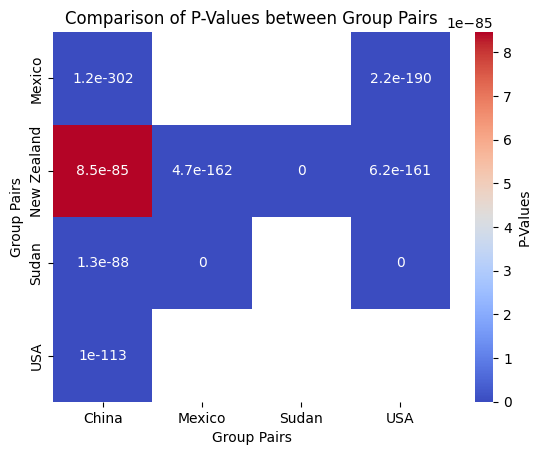

In [21]:


# Create a DataFrame with 'location' and 'kmeans_label' columns

# Create a contingency table for each pair of groups
groups = color_df['location'].unique()
n_groups = len(groups)
contingency_tables = {}
for i in range(n_groups):
    for j in range(i+1, n_groups):
        group1 = groups[i]
        group2 = groups[j]
        contingency_table = pd.crosstab(color_df['location'], color_df['kmeans_label'], margins=False)
        contingency_table = contingency_table.loc[[group1, group2]]
        contingency_tables[(group1, group2)] = contingency_table.values

        

import seaborn as sns
import matplotlib.pyplot as plt

# Create a list of group pairs and corresponding p-values
group_pair1 = []
group_pair2 = []
p_values = []
for group_pair, contingency_table in contingency_tables.items():
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    group_pair1.append(group_pair[0])
    group_pair2.append(group_pair[1])
    p_values.append(p_value)

# Convert group pairs and p-values to DataFrame
data = pd.DataFrame({'Group Pair1': group_pair1, 'Group Pair2': group_pair2, 'P-Values': p_values})
# Reset index to make column names unique
data = data.reset_index(drop=True)

print(data)

# Create a pivot table to reshape the data for heatmap
pivot_data = data.pivot(index='Group Pair1', columns='Group Pair2', values='P-Values')

print(pivot_data)

# Create a heatmap
sns.heatmap(pivot_data, annot=True, cmap='coolwarm', cbar_kws={'label': 'P-Values'})
plt.xlabel('Group Pairs')
plt.ylabel('Group Pairs')
plt.title('Comparison of P-Values between Group Pairs')
plt.show()
    
    


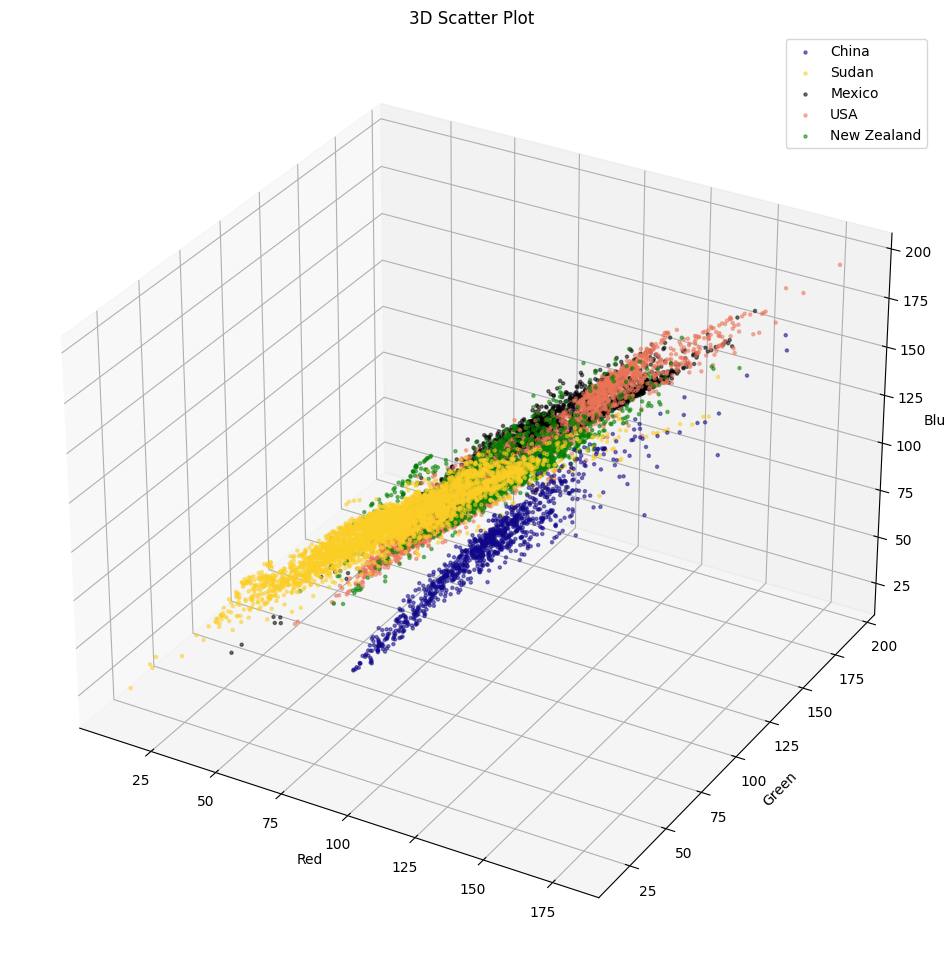

In [22]:


cmap = plt.get_cmap('plasma')

# Create a 3D plot
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111, projection='3d')

colors = {'New Zealand': 'green',
         'USA': cmap(.65),
         'Mexico':'black',
         'Sudan':cmap(.9),
         'China':cmap(1),}

for group in reversed(colors.keys()):
    group_df = color_df[color_df['location'] == group]
    ax.scatter(group_df['red'], group_df['green'], group_df['blue'], color=colors[group], marker='.', label=group, alpha = .5)

# Set labels for axes
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')

ax.legend()

# Set title for the plot
ax.set_title('3D Scatter Plot')
# Rotate the plot
#ax.view_init(elev=20, azim=5)  # Example elevation and azimuthal angles

# Show the plot
plt.show()

## Correlation Plot

In [80]:
### THIS IS OUTPUT TAKEN FROM THE EXPERIMENT_2 FILE. ### 

test_dict = {'Mexico': {'Mexico': 1.7473988826466842,
  'NZ': 0.7092007907518415,
  'China': 0.2925659763038727,
  'USA': 3.285762078236884,
  'Sudan': 0.14668133480014667},
 'NZ': {'Mexico': 0.6218713269946746,
  'NZ': 32.49877604139578,
  'China': 0.22119233199915733,
  'USA': 2.821942141831612,
  'Sudan': 0.5362156684751631},
 'USA': {'Mexico': 3.28404146437597,
  'NZ': 3.9711659150370706,
  'China': 0.5542441140362249,
  'USA': 24.270375575009698,
  'Sudan': 0.06306363120388472},
 'Sudan': {'Mexico': 0.040412204485754694,
  'NZ': 0.3517494153977413,
  'China': 12.117309546411747,
  'USA': 0.14040350071814425,
  'Sudan': 46.51939879904925}}

In [81]:
# for-loop to calculate the R2 and variance for the countries

cross_corr = {}
for c_a in test_dict.keys():

    for c_b in test_dict[c_a].keys():
        print(c_b)
        
        if c_a == c_b:
            continue
        
        cross_corr[f"{c_a}_{c_b}"] = {}
        cross_corr[f"{c_a}_{c_b}"]['AP50'] = test_dict[c_a][c_b]
        if c_b == 'NZ':
            c_bx = 'New Zealand'
        else: 
            c_bx = c_b        
        
        if c_a == 'NZ':
            c_ax = 'New Zealand'
        else:
            c_ax = c_a
            
        cross_corr[f"{c_a}_{c_b}"]['country_a'] = c_a
        cross_corr[f"{c_a}_{c_b}"]['country_b'] = c_b
        
        # Calculate the R2 distance
        cross_corr[f"{c_a}_{c_b}"]['r2'] = np.float(np.linalg.norm(
            np.asarray(
                [aggregated[aggregated['location'] == c_ax]['red_mean'].values[0], 
                 aggregated[aggregated['location'] == c_ax]['green_mean'].values[0],
                 aggregated[aggregated['location'] == c_ax]['blue_mean'].values[0]] - np.asarray([aggregated[aggregated['location'] == c_bx]['red_mean'].values[0], 
                                                                                                aggregated[aggregated['location'] == c_bx]['green_mean'].values[0], 
                                                                                                aggregated[aggregated['location'] == c_bx]['blue_mean'].values[0]]))))
        # calculate the variance of the training country
        cross_corr[f"{c_a}_{c_b}"]['var'] = np.float(np.mean(np.asarray([aggregated[aggregated['location'] == c_ax]['red_std'].values[0],
                                                               aggregated[aggregated['location'] == c_ax]['green_std'].values[0], 
                                                               aggregated[aggregated['location'] == c_ax]['blue_std'].values[0]])))


Mexico
NZ
China
USA
Sudan
Mexico
NZ
China
USA
Sudan
Mexico
NZ
China
USA
Sudan
Mexico
NZ
China
USA
Sudan


<ipython-input-81-31f9008d58e0>:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cross_corr[f"{c_a}_{c_b}"]['r2'] = np.float(np.linalg.norm(
<ipython-input-81-31f9008d58e0>:33: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cross_corr[f"{c_a}_{c_b}"]['var'] = np.float(np.mean(np.asarray([aggregated[aggregated['location'] == c_ax]['red_std

In [82]:
df_corr = pd.DataFrame(cross_corr)

In [83]:
# pivot dataframe
df_corr = df_corr.transpose()
df_corr

,AP50,country_a,country_b,r2,var
Mexico_NZ,0.709201,Mexico,NZ,25.731239,16.174459
Mexico_China,0.292566,Mexico,China,55.388356,16.174459
Mexico_USA,3.285762,Mexico,USA,18.532385,16.174459
Mexico_Sudan,0.146681,Mexico,Sudan,62.245417,16.174459
NZ_Mexico,0.621871,NZ,Mexico,25.731239,14.451115
NZ_China,0.221192,NZ,China,32.292737,14.451115
NZ_USA,2.821942,NZ,USA,7.584588,14.451115
NZ_Sudan,0.536216,NZ,Sudan,38.085744,14.451115
USA_Mexico,3.284041,USA,Mexico,18.532385,23.982516
USA_NZ,3.971166,USA,NZ,7.584588,23.982516


In [84]:
# transform data

df_corr['AP50'] = [(i**.5) for i in df_corr['AP50'].values]
df_corr['log_AP50'] = [np.log(i) for i in df_corr['AP50'].values]
df_corr['log_AP50+1'] = [np.log(i+1) for i in df_corr['AP50'].values]
df_corr['AP50_root'] = [(i**.5) for i in df_corr['AP50'].values]
df_corr['r2_squared'] = [(i**2) for i in df_corr['r2'].values]

df_corr['r2'] = [i for i in df_corr['r2'].values]
df_corr['var'] = [i for i in df_corr['var'].values]
df_corr['country_a'] = [i for i in df_corr['country_a'].values]

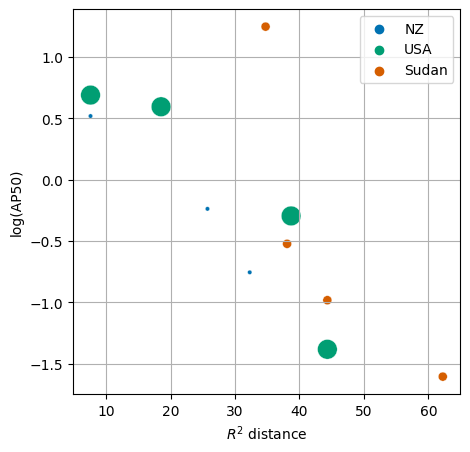

In [85]:
from sklearn.linear_model import LinearRegression



fig, ax = plt.subplots(figsize = (5,5))
ms_dict = {
    'USA': 1, 'NZ':2,'Mexico':3,'Sudan':4
}

sns.scatterplot(data = df_corr[df_corr['country_a'] != 'Mexico'], 
                x = 'r2', 
                y= 'log_AP50', 
                hue = 'country_a', 
                size = 'var', 
                sizes=(10, 200), 
                ax = ax,
                #style = 'country_a',
                legend = 'brief')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles[1:4], labels=labels[1:4],
           loc = 1,
          ncol=1, 
           #bbox_to_anchor=[1,-.3,0,0]
          )
ax.set_xlabel('$R^2$ distance')
ax.set_ylabel('log(AP50)')
plt.grid()
plt.savefig('/workspace/figures/exp2_correlation_newmexico', bbox_inches = 'tight')
plt.show()



In [86]:
# Run the linear Regression that is shown in Appendix
from statsmodels.api import OLS
print(OLS(df_corr[df_corr['country_a'] != 'Mexico']['log_AP50'],df_corr[df_corr['country_a'] != 'Mexico'][['r2', 'var']], hasconst=True).fit().summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &    log\_AP50     & \textbf{  R-squared:         } &     0.505   \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &     0.455   \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &     10.19   \\
\textbf{Date:}             & Mon, 24 Apr 2023 & \textbf{  Prob (F-statistic):} &  0.00962    \\
\textbf{Time:}             &     10:43:16     & \textbf{  Log-Likelihood:    } &   -10.682   \\
\textbf{No. Observations:} &          12      & \textbf{  AIC:               } &     25.36   \\
\textbf{Df Residuals:}     &          10      & \textbf{  BIC:               } &     26.33   \\
\textbf{Df Model:}         &           1      & \textbf{                     } &             \\
\textbf{Covariance Type:}  &    nonrobust     & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
             & \textbf{coef} & \textbf{

/usr/local/lib/python3.8/dist-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


helo
